# Product Competion Time Prediction

In [ ]:
import tensorflow as tf
import numpy as np
import json
import time
import pickle
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

## Load Data

The data is given in recurrent sequence. We fill the data to the maximum possible length.

- **x_node_type**: The type of each recurrent units, 0-machine, 1-product
- **x_node_feature**: The feature for each recurrent units
- **y_location**: The lower bound given by system model
- **y_makespan**: The PCT for each product

The data is collected from the system with the following parameters:
- **Machine Number**: 8
- **Buffer Capacities**: 5 for each machine
- **Incoming Products Included**: 5
- **Total Prodcut Types**: 10

The total number of datapoints is 10,000

In [27]:
# The maximum length of a recurrent sequence input is 48
d0 = 10000
d1 = 48
# Data directory
d = './data'

# Import x_node_type
with open(d+'/x_node_type.json', 'r') as fname:
    temp = json.load(fname)
    x_typ = np.zeros((d0, d1, 1))
    for i in range(d0):
        for j in range(len(temp[i])):
            x_typ[i, j] = temp[i][j]

# Import x_node_feature
temp = []
for i in range(5):
    with open(d+'/x_node_feature_%g.json'%i, 'r') as fname:
        temp += json.load(fname)

# Pre-process x_node_type        
x_ftr = np.zeros((d0, d1, 10))
mach_ftr = np.zeros((d0, 8))
for i in range(d0):
    mach_idx = 1
    mach = []
    first_prod = True
    for j in range(len(temp[i])):
        if x_typ[i, j, 0] == 1:

            x_ftr[i, j] = temp[i][j]
            x_ftr[i, j] /= 5

            if first_prod:
                # if this is the 1st product encountered
                for m in mach:
                    mach_ftr[i, -m] = x_ftr[i, j, -m]

            first_prod = False
            mach = []

        elif x_typ[i, j, 0] == 0:
            # This is a machine
            mach.append(mach_idx)
            mach_idx += 1
            x_ftr[i, j] = temp[i][j]
            first_prod = True

    for i in range(d0):
        m = 1
        for j in range(len(temp[i])):
            if x_typ[i, j, 0] == 0:
                x_ftr[i, j, 1] = mach_ftr[i, -m] * (1 - x_ftr[i, j, 1])
                m += 1

            
# Import y_location                
with open(d+'/y_location.json', 'r') as fname:
    temp = json.load(fname)
    y_loc = np.zeros((d0, d1, 1))
    for i in range(d0):
        for j in range(len(temp[i])):
            y_loc[i, j] = temp[i][j]

# Import y_makespan           
with open(d+'/y_makespan.json', 'r') as fname:
    temp = json.load(fname)
    y_mkp = np.zeros((d0, s1, 1))
    for i in range(d0):
        for j in range(len(temp[i])):
            y_mkp[i, j] = temp[i][j]
            

print("Success: %g datapoints loaded" % len(y_loc))

# y_lstm is the output of the LSTM
# We only predict the distance between lower bound and PCT
y_lstm = y_mkp - y_loc


10000 datapoints loaded


### Split Dataset
Split the data by a 70:30 ratio to trainset and testset

#### Shuffling Data

In [28]:
# Function for shuffling data
def shuffle(arr, N, seed=123):
    idx = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    res = []
    for data in arr:
        res.append(data[idx])
    
    return res
        

In [29]:
# Total number of data points
N = len(x_typ)

[x_ftr, x_typ, y_lstm, y_loc, y_mkp] = shuffle([x_ftr, x_typ, y_lstm, y_loc, y_mkp], N)

N_train = int(N * 0.7)

traindata = [[x_ftr[:N_train], x_typ[:N_train]], y_lstm[:N_train]]
testdata = [[x_ftr[N_train:], x_typ[N_train:]], y_lstm[N_train:]]

test_loc = y_loc[N_train:]


## Consturct Computation Graph

### Loss Function for Training
Since we fill the data with zeros, we need to exclude those positions

In [30]:
def loss_fn(y_pred, y_true):
    mse = tf.reduce_mean((y_pred[y_true!=0] - y_true[y_true!=0])**2)
    return mse

### Model Architecture

In [ ]:
# Model Parameters
lstm_units = 128
dense_units = 128
reg_l1, reg_l2 = 0.08, 0.1
epochs = 200
batch_size = 32
dropout = 0.2

input1 = tf.keras.Input(shape=(d1, 10), name='node_feature')
mask = tf.keras.Input(shape=(d1, 1), name='node_type')

# First LSTM layer
h1 = tf.keras.layers.LSTM(lstm_units,
                          return_sequences=True,
                          return_state=False,
                          dropout=dropout
                          )(input1)

# Normalize the outputs for LSTM_1
h1 = tf.keras.layers.LayerNormalization(axis=1)(h1)

# Skip-level connection
input2 = tf.keras.layers.Concatenate(axis=-1)([h1, input1])

# Second LSTM layer
h2 = tf.keras.layers.LSTM(lstm_units,
                          return_sequences=True,
                          return_state=False,
                          dropout=dropout
                          )(input2)

# Normalize the outputs for LSTM_2
h2 = tf.keras.layers.LayerNormalization(axis=1)(h2)

# Skip-level connection
input3 = tf.keras.layers.Concatenate(axis=-1)([h1, h2])

# MLP layer 1
x = tf.keras.layers.Dense(dense_units,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1_l2(reg_l1, reg_l2)
                          )(input3)

# MLP layer 2
x = tf.keras.layers.Dense(dense_units,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1_l2(reg_l1, reg_l2)
                          )(x)
# MLP layer 3
x = tf.keras.layers.Dense(dense_units,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l1_l2(reg_l1, reg_l2)
                          )(x)

# Output layer
x = tf.keras.layers.Dense(1)(x)

# Mask output for machine units and null units
y = tf.keras.layers.multiply([x, mask])

# Assemble Model
model = tf.keras.Model(inputs=[input1, mask], outputs=y)


### Optimizer
The RMSprop is used, with learning rate adapted to 0.0001

Gradient clipping is used to avoid gradient explosion

Gradient clipped by [-1, 1]

In [ ]:
optim = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0, epsilon=1e-07, clipvalue=1.)


### Model Compiling and Training

In [ ]:
model.compile(optimizer=optim,
              loss=loss_fn,
              metrics=[tf.keras.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.RootMeanSquaredError()])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_square', patience=20)

# Training
hist = model.fit(x=traindata[0], y=traindata[1], validation_data=testdata, verbose=1, epochs=epochs, batch_size=batch_size, callbacks=[callback])

## Visulization

In [32]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error'])


### Learning Curve

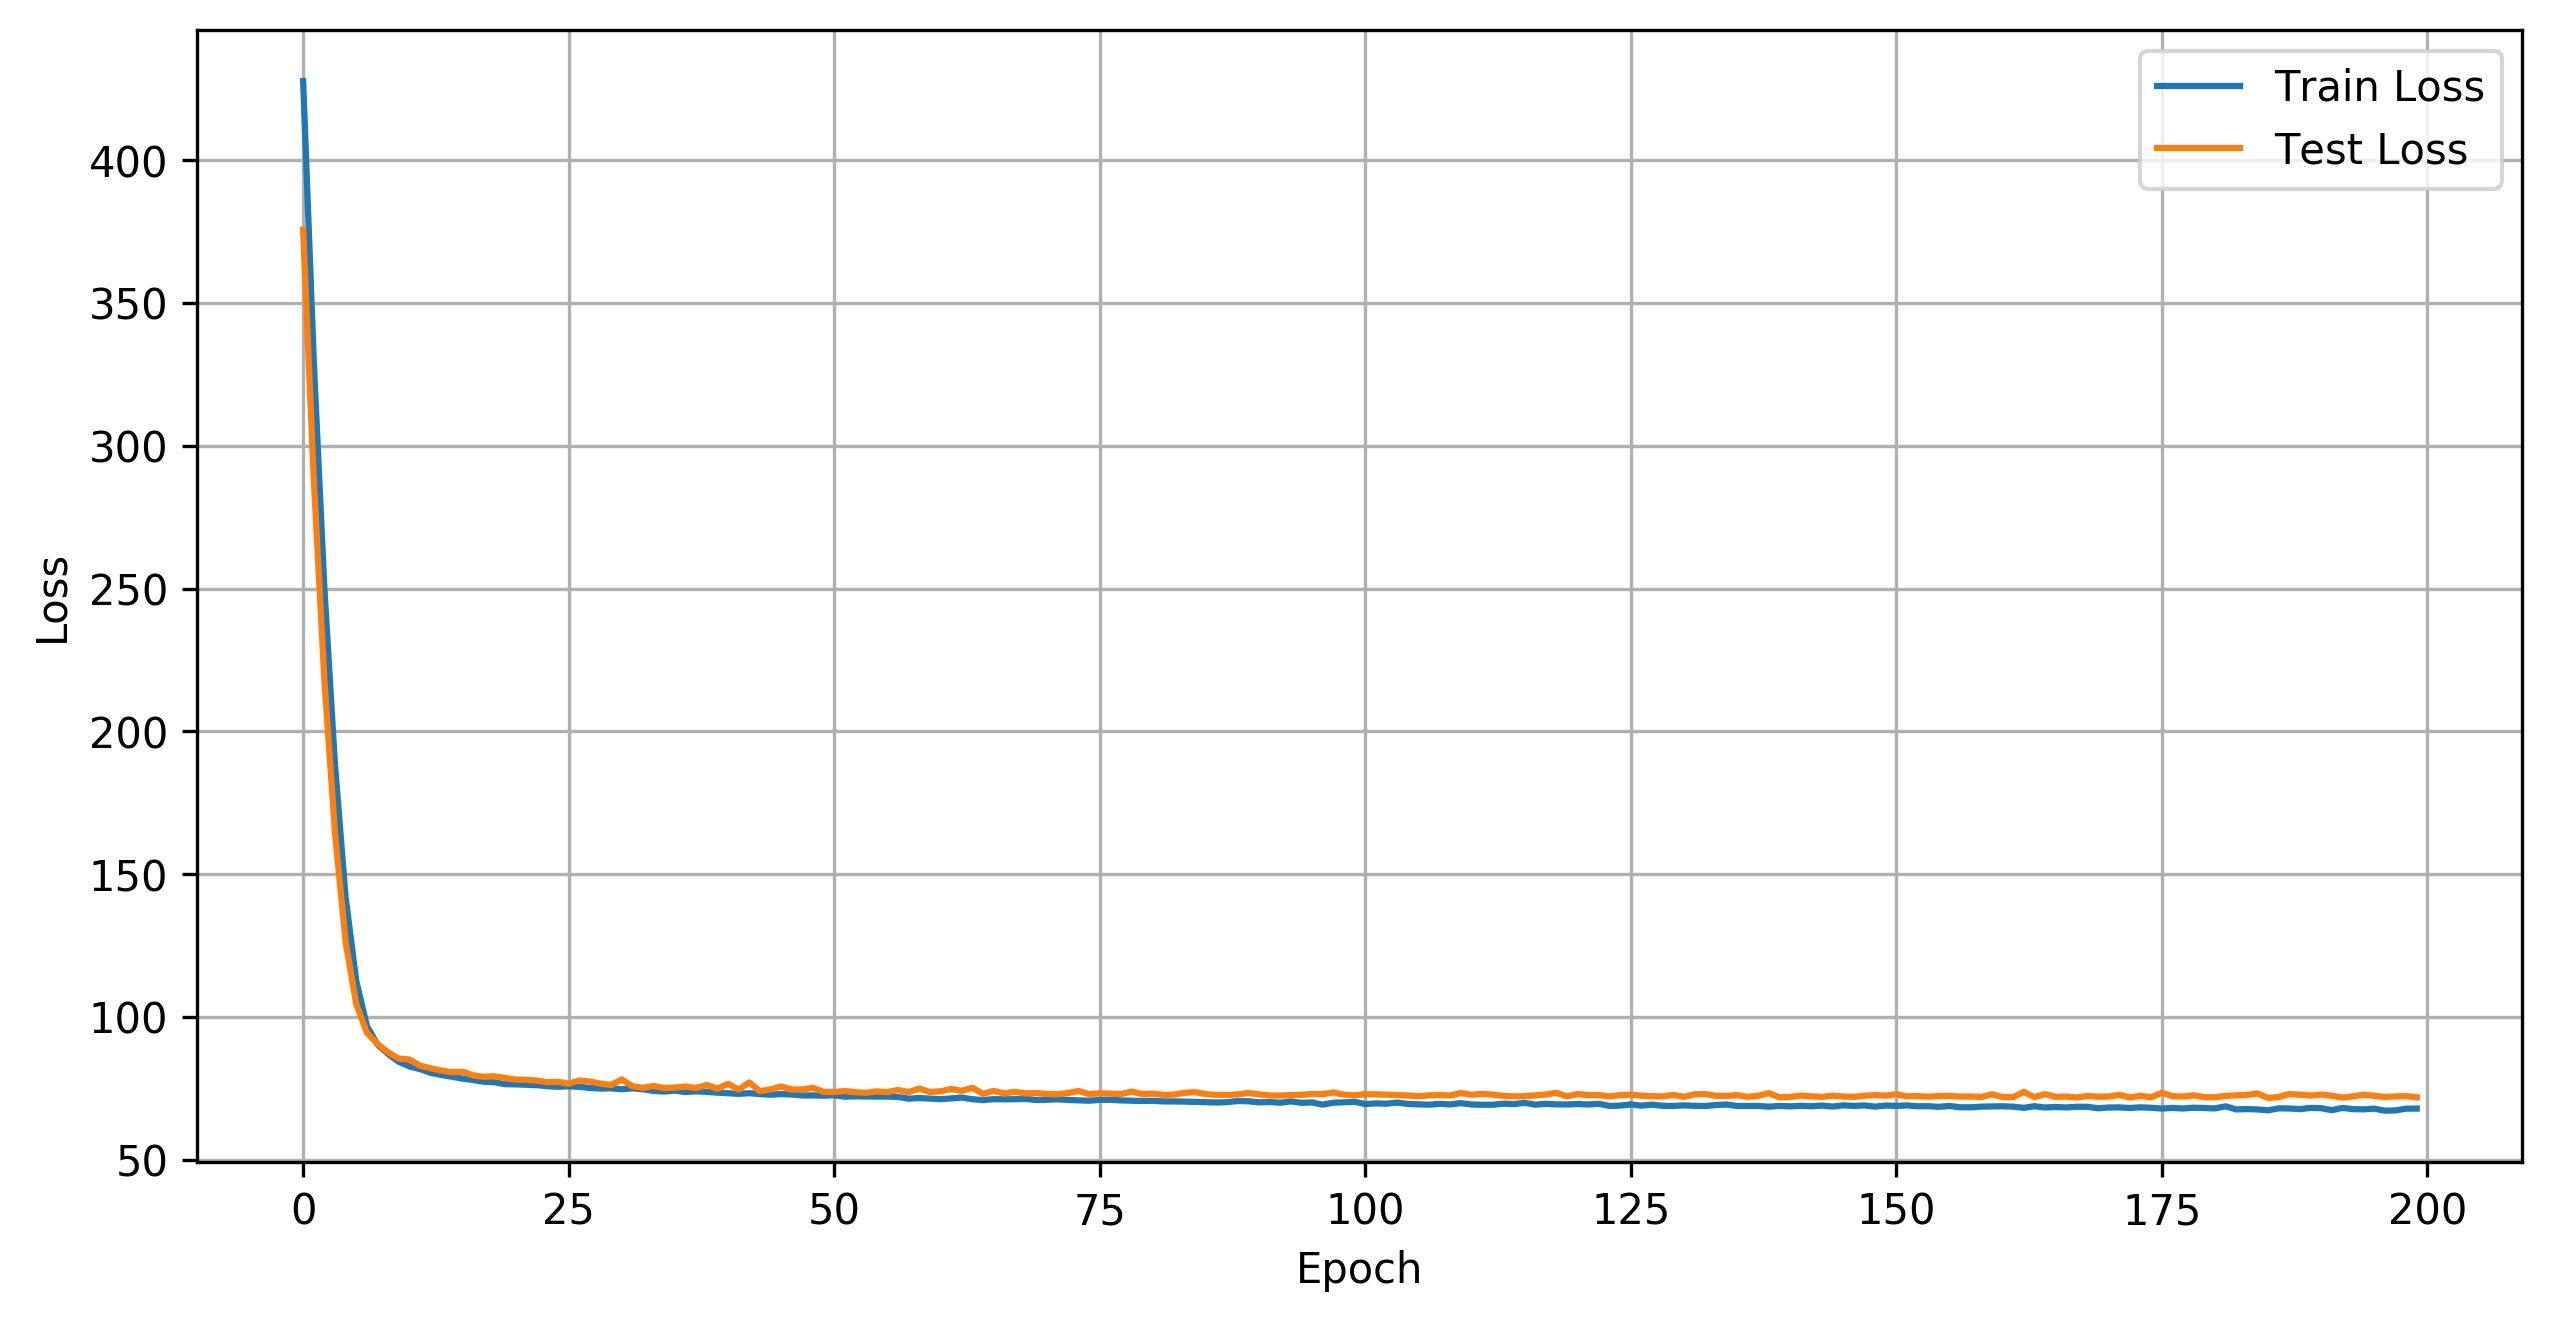

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 5], dpi=300)
plt.plot(hist.history['loss'])#[:101])
plt.plot(hist.history['val_loss'])#[:101])

plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.savefig('Training_process.png')
plt.show()

### Root Mean Square Error
Remark: This RMSE is not equal to the true RMSE since the model include the null units masked out. But the trend remains the same

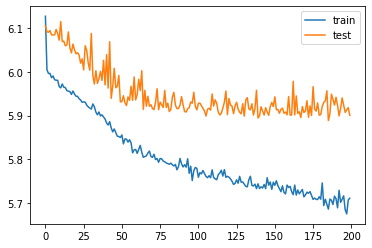

In [48]:
plt.figure()
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])

plt.legend(['train', 'test'])

plt.show()

### PCT Prediction Showcase

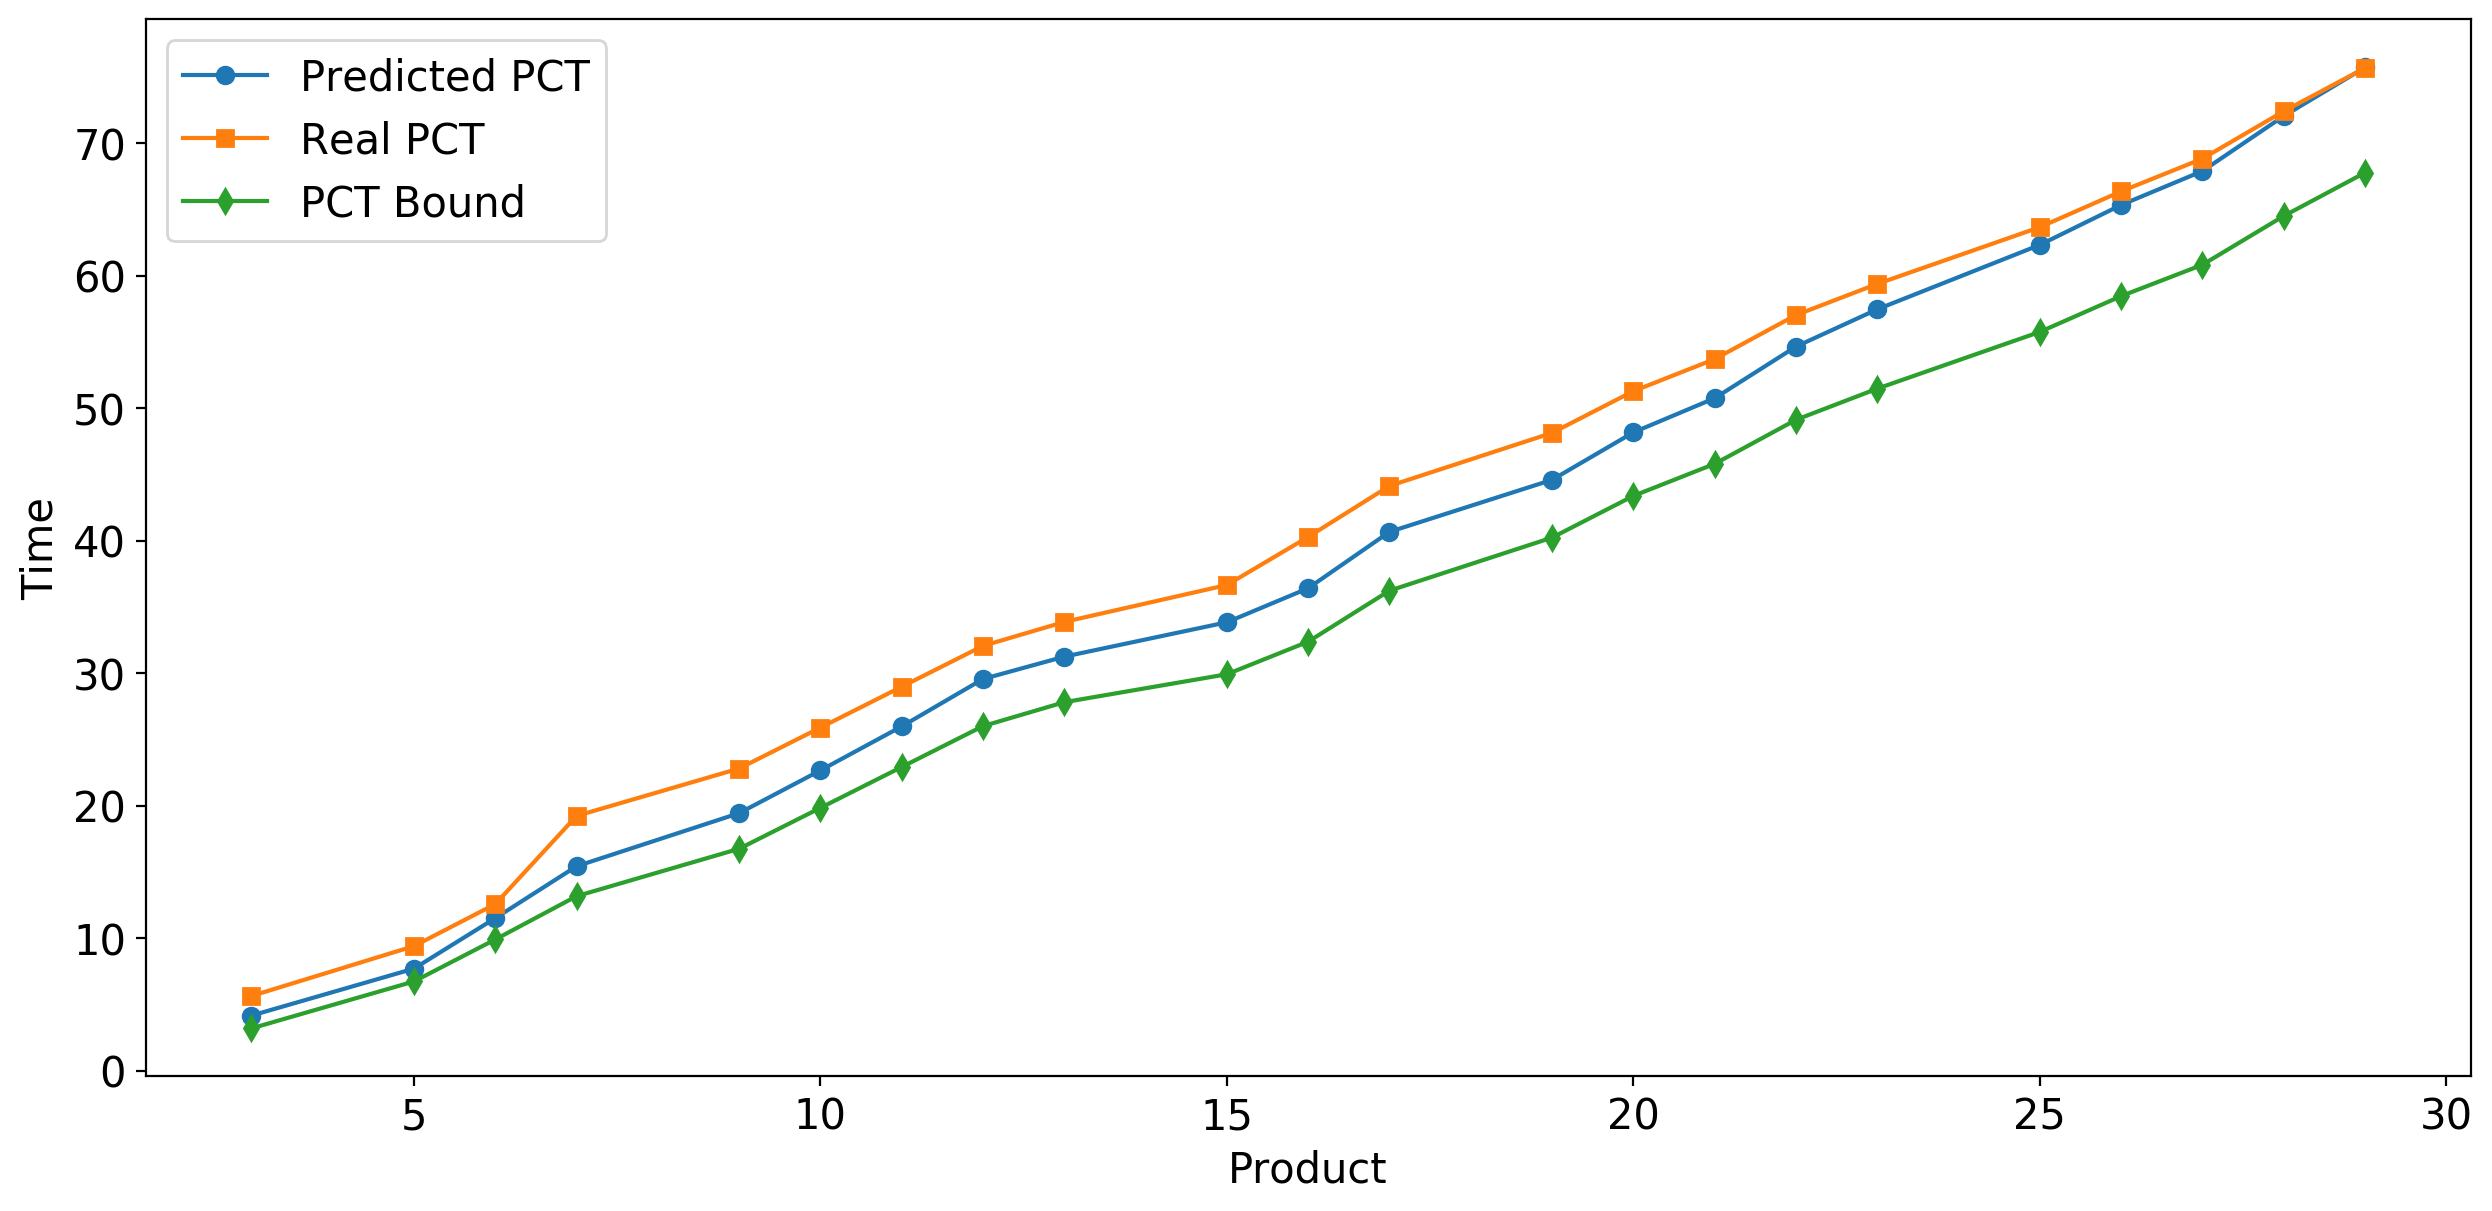

In [38]:
import matplotlib.pyplot as plt

# Predicted Value
y_pred = model.predict(x=testdata[0])
y_pred = y_pred

# Actual Value
y_real = testdata[1]

idx = 128

xx = [x for x in range(48) if testdata[0][1][idx][x] == 1 ]

yy_pred = (y_pred[idx] + test_loc[idx])[testdata[0][1][idx] == 1]

yy_real = (y_real[idx] + test_loc[idx])[testdata[0][1][idx] == 1]

yy_loc = test_loc[idx][testdata[0][1][idx] == 1]

#plt.figure(figsize=[10, 5], dpi=400)

fig, ax = plt.subplots(figsize=(15,7), dpi=200)


ax.plot(xx, yy_pred, marker='o')
ax.plot(xx, yy_real, marker='s')
ax.plot(xx, yy_loc, marker='d')
ax.legend(['Predicted PCT', 'Real PCT', 'PCT Bound'], fontsize = 15.0)

ax.set_ylabel('Time', fontsize = 15.0)
ax.set_xlabel('Product', fontsize = 15.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
        
    ax.invert_xaxis()

fig.savefig('prediction.png')
fig.show()


## Model Performance Evaluation

### MAE

In [41]:
mae = np.mean(np.abs(y_pred[y_real!=0] - y_real[y_real!=0]))
print("Mean Absolute Error: %g" % mae)

Mean Absolute Error: 5.1561


### MAPE

In [44]:
mape = np.mean(np.abs((y_real[y_real!=0] - y_pred[y_real!=0]) / y_real[y_real!=0]))
print("Mean Absolute Percentage Error: %g%%" % (mape*100))

Mean Absolute Percentage Error: 20.562%


### MSE

In [43]:
mse = np.mean((y_pred[y_real!=0] - y_real[y_real!=0]) ** 2)
print("Mean Square Error: %g" % mse)

Mean Square Error: 69.2975


### RMSE

In [46]:
rmse = np.sqrt(np.mean((y_pred[y_real!=0] - y_real[y_real!=0]) ** 2))
print("Root Mean Square Error: %g" % rmse)

Root Mean Square Error: 8.32451


### R-square

In [47]:
r2 = 1 - np.sum((y_real[y_real!=0] - y_pred[y_real!=0]) ** 2) / np.sum((np.mean(y_real[y_real!=0]) - y_real[y_real!=0]) ** 2)
print("R2: %g" % r2)

R2: 0.914291
